# Multi-Horizon Stock Return & Direction Prediction

## Overview
This notebook implements a **fundamentally different approach** from the previous price prediction model:
- **Target**: Predict 7-day **returns** and **direction** (not absolute prices)
- **Why**: Stock prices follow a near-random walk; returns are stationary and more predictable
- **Multi-task**: Simultaneously predict return percentage AND direction (UP/DOWN)
- **Evaluation**: Focus on directional accuracy and trading profitability, not just R²

### Key Improvements:
1. **Returns vs Prices**: Predict percentage change, making predictions scale-invariant
2. **Direction Classification**: Binary prediction (UP/DOWN) for actionable trading signals
3. **Trading Metrics**: Evaluate with Sharpe ratio, profit/loss simulation, win rate
4. **Realistic Baselines**: Compare against naive (0% return) and buy-and-hold
5. **Walk-Forward Validation**: Time-based splits for realistic evaluation

### Models Evaluated:
1. Multi-task LSTM (regression + classification)
2. Multi-task GRU
3. Separate models: Logistic Regression (direction) + XGBoost (returns)
4. Linear Regression baseline

---
## 1. Imports and Setup

In [2]:
# Standard libraries
import os
import glob
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

# XGBoost
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# Progress bars
from tqdm.auto import tqdm

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.keras

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")

2025-11-13 23:18:52.652409: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-13 23:18:59.166660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-13 23:19:22.657304: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


All libraries imported successfully
TensorFlow version: 2.20.0
XGBoost version: 3.1.1


In [18]:
# Configuration
WINDOW_SIZE = 60          # Input: past 60 days of features
HORIZON = 7               # Output: predict 7-day ahead return & direction
TEST_STOCK_RATIO = 0.2    # 20% of stocks for testing
RANDOM_STATE = 42

# Paths
DATA_DIR = Path("data/processed/stock_data")
MODELS_DIR = Path("models")
MLFLOW_DIR = Path("mlruns")

MODELS_DIR.mkdir(exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"MLflow tracking: {MLFLOW_DIR}")

Data directory: data/processed/stock_data
Models directory: models
MLflow tracking: mlruns


In [19]:
# MLflow Setup
mlflow.set_tracking_uri(f"file://{MLFLOW_DIR.absolute()}")
mlflow.set_experiment("stock-return-prediction-multihorizon")

experiment = mlflow.get_experiment_by_name("stock-return-prediction-multihorizon")
print(f"MLflow Experiment: {experiment.name}")
print(f"Experiment ID: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")

MLflow Experiment: stock-return-prediction-multihorizon
Experiment ID: 785296905155056667
Artifact Location: file:///home/labeeb/Desktop/stock-curator/mlruns/785296905155056667


---
## 2. Load & Preprocess Data

In [20]:
# Load all stock CSV files
csv_files = sorted(glob.glob(str(DATA_DIR / "*_historical.csv")))

print(f"Found {len(csv_files)} stock CSV files")
print(f"\nFirst 5 files:")
for f in csv_files[:5]:
    print(f"  - {Path(f).name}")

Found 98 stock CSV files

First 5 files:
  - ABBOTINDIA_historical.csv
  - ABB_historical.csv
  - ADANIENT_historical.csv
  - ADANIGREEN_historical.csv
  - ADANIPORTS_historical.csv


In [21]:
def load_stock_data(file_path):
    """
    Load a single stock CSV and preprocess it.
    """
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    df_clean = df.dropna()
    
    # Need at least WINDOW_SIZE + HORIZON rows
    if len(df_clean) < WINDOW_SIZE + HORIZON:
        return None
    
    return df_clean


# Load all stocks
stock_data = {}
skipped = []

for file_path in csv_files:
    symbol = Path(file_path).stem.replace('_historical', '')
    df = load_stock_data(file_path)
    
    if df is not None:
        stock_data[symbol] = df
    else:
        skipped.append(symbol)

print(f"Loaded {len(stock_data)} stocks successfully")
if skipped:
    print(f"Skipped {len(skipped)} stocks: {skipped}")

Loaded 98 stocks successfully


In [22]:
# Inspect sample data
sample_symbol = list(stock_data.keys())[0]
sample_df = stock_data[sample_symbol]

print(f"\nSample Stock: {sample_symbol}")
print(f"Shape: {sample_df.shape}")
print(f"Date Range: {sample_df['Date'].min()} to {sample_df['Date'].max()}")
print(f"\nColumns ({len(sample_df.columns)}):")
print(sample_df.columns.tolist())
print(f"\nFirst 3 rows:")
print(sample_df.head(3))


Sample Stock: ABBOTINDIA
Shape: (447, 28)
Date Range: 2024-01-15 00:00:00+05:30 to 2025-10-31 00:00:00+05:30

Columns (28):
['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OI', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'Volume_SMA_20', 'Volume_Ratio', 'Daily_Return', 'Price_Range', 'Price_Change', 'Symbol', 'Name', 'ISIN']

First 3 rows:
                        Date     Open      High       Low     Close  Volume  \
49 2024-01-15 00:00:00+05:30  25700.0  26381.65  25700.00  26210.45   33616   
50 2024-01-16 00:00:00+05:30  26220.0  26305.90  25601.00  25806.50   51548   
51 2024-01-17 00:00:00+05:30  25600.0  26139.95  25546.15  25730.70   15925   

    OI     SMA_5     SMA_10      SMA_20  ...      BB_Upper      BB_Lower  \
49   0  25228.03  24418.650  23511.0825  ...  25865.034135  21157.130865   
50   0  25542.95  24666.575  23662.3925  ...  26200.405545  21124.379455   
51   0  25767

---
## 3. Feature Engineering - Add Return-Based Features

In [23]:
def add_return_features(df):
    """
    Add return-based features for better stationarity.
    """
    df = df.copy()
    
    # Historical returns (already have Daily_Return = 1-day return)
    df['Return_3d'] = df['Close'].pct_change(3) * 100
    df['Return_5d'] = df['Close'].pct_change(5) * 100
    df['Return_10d'] = df['Close'].pct_change(10) * 100
    
    # Log returns for better stationarity
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1)) * 100
    
    # Volatility (rolling std of returns)
    df['Volatility_5d'] = df['Daily_Return'].rolling(5).std()
    df['Volatility_20d'] = df['Daily_Return'].rolling(20).std()
    
    # Momentum indicators
    df['Momentum_10d'] = df['Close'] - df['Close'].shift(10)
    df['Momentum_20d'] = df['Close'] - df['Close'].shift(20)
    
    # Drop NaN rows created by new features
    df = df.dropna()
    
    return df


# Apply to all stocks
print("Adding return-based features...")
for symbol in stock_data.keys():
    stock_data[symbol] = add_return_features(stock_data[symbol])

print(f"Feature engineering complete")
print(f"\nUpdated feature count: {len([col for col in stock_data[sample_symbol].columns if col not in ['Date', 'Symbol', 'Name', 'ISIN']])}")

Adding return-based features...
Feature engineering complete

Updated feature count: 32


In [24]:
# Define feature columns (exclude metadata)
exclude_cols = ['Date', 'Symbol', 'Name', 'ISIN']
feature_cols = [col for col in stock_data[sample_symbol].columns if col not in exclude_cols]

print(f"\nFeature Columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")


Feature Columns (32):
   1. Open
   2. High
   3. Low
   4. Close
   5. Volume
   6. OI
   7. SMA_5
   8. SMA_10
   9. SMA_20
  10. SMA_50
  11. EMA_12
  12. EMA_26
  13. MACD
  14. MACD_Signal
  15. MACD_Hist
  16. RSI
  17. BB_Middle
  18. BB_Upper
  19. BB_Lower
  20. Volume_SMA_20
  21. Volume_Ratio
  22. Daily_Return
  23. Price_Range
  24. Price_Change
  25. Return_3d
  26. Return_5d
  27. Return_10d
  28. Log_Return
  29. Volatility_5d
  30. Volatility_20d
  31. Momentum_10d
  32. Momentum_20d


---
## 4. Create Target Variables: Returns & Direction

In [25]:
def create_sequences_with_returns(df, window_size=60, horizon=7):
    """
    Create sliding window sequences with return and direction targets.
    
    Returns:
        X: (n_samples, window_size, n_features) - input features
        y_return: (n_samples,) - 7-day cumulative return %
        y_direction: (n_samples,) - 1 if UP, 0 if DOWN
    """
    features = df[feature_cols].values
    close_prices = df['Close'].values
    
    X, y_return, y_direction = [], [], []
    
    for i in range(len(df) - window_size - horizon + 1):
        # Input: past window_size days of all features
        X.append(features[i:i + window_size])
        
        # Current close price (last day of input window)
        current_close = close_prices[i + window_size - 1]
        
        # Future close price (horizon days ahead)
        future_close = close_prices[i + window_size + horizon - 1]
        
        # Calculate 7-day return percentage
        return_pct = ((future_close - current_close) / current_close) * 100
        y_return.append(return_pct)
        
        # Calculate direction (1 = UP, 0 = DOWN)
        direction = 1 if future_close > current_close else 0
        y_direction.append(direction)
    
    return np.array(X), np.array(y_return), np.array(y_direction)


# Test on sample stock
X_test, y_ret_test, y_dir_test = create_sequences_with_returns(stock_data[sample_symbol], WINDOW_SIZE, HORIZON)

print(f"\nTest Sequence Creation on {sample_symbol}:")
print(f"  X shape:          {X_test.shape}  <- (samples, window_size, features)")
print(f"  y_return shape:   {y_ret_test.shape}  <- 7-day return %")
print(f"  y_direction shape: {y_dir_test.shape}  <- UP/DOWN (1/0)")
print(f"\n  Example:")
print(f"    Return:    {y_ret_test[0]:.2f}%")
print(f"    Direction: {y_dir_test[0]} ({'UP' if y_dir_test[0] == 1 else 'DOWN'})")
print(f"\n  Class distribution:")
print(f"    UP (1):   {np.sum(y_dir_test == 1)} ({np.mean(y_dir_test == 1)*100:.1f}%)")
print(f"    DOWN (0): {np.sum(y_dir_test == 0)} ({np.mean(y_dir_test == 0)*100:.1f}%)")


Test Sequence Creation on ABBOTINDIA:
  X shape:          (361, 60, 32)  <- (samples, window_size, features)
  y_return shape:   (361,)  <- 7-day return %
  y_direction shape: (361,)  <- UP/DOWN (1/0)

  Example:
    Return:    -3.26%
    Direction: 0 (DOWN)

  Class distribution:
    UP (1):   172 (47.6%)
    DOWN (0): 189 (52.4%)


---
## 5. Train/Test Split & Data Preparation

In [26]:
# Split stocks into train and test sets
stock_symbols = list(stock_data.keys())
n_test_stocks = int(len(stock_symbols) * TEST_STOCK_RATIO)

np.random.seed(RANDOM_STATE)
shuffled_symbols = np.random.permutation(stock_symbols)

train_symbols = shuffled_symbols[:-n_test_stocks]
test_symbols = shuffled_symbols[-n_test_stocks:]

print(f"\nStock Split:")
print(f"  Training stocks: {len(train_symbols)} ({len(train_symbols)/len(stock_symbols)*100:.1f}%)")
print(f"  Test stocks:     {len(test_symbols)} ({len(test_symbols)/len(stock_symbols)*100:.1f}%)")


Stock Split:
  Training stocks: 79 (80.6%)
  Test stocks:     19 (19.4%)


In [27]:
# Create sequences for training stocks
print("\nCreating sequences for training stocks...")
X_train_list, y_return_train_list, y_dir_train_list = [], [], []

for symbol in tqdm(train_symbols, desc="Processing train stocks"):
    df = stock_data[symbol]
    X, y_ret, y_dir = create_sequences_with_returns(df, WINDOW_SIZE, HORIZON)
    X_train_list.append(X)
    y_return_train_list.append(y_ret)
    y_dir_train_list.append(y_dir)

X_train = np.concatenate(X_train_list, axis=0)
y_return_train = np.concatenate(y_return_train_list, axis=0)
y_direction_train = np.concatenate(y_dir_train_list, axis=0)

print(f"\nTraining set:")
print(f"  X_train: {X_train.shape}")
print(f"  y_return_train: {y_return_train.shape}")
print(f"  y_direction_train: {y_direction_train.shape}")
print(f"  UP/DOWN ratio: {np.mean(y_direction_train == 1)*100:.1f}% UP")


Creating sequences for training stocks...


Processing train stocks:   0%|          | 0/79 [00:00<?, ?it/s]


Training set:
  X_train: (28519, 60, 32)
  y_return_train: (28519,)
  y_direction_train: (28519,)
  UP/DOWN ratio: 51.3% UP


In [28]:
# Create sequences for test stocks
print("\nCreating sequences for test stocks...")
X_test_list, y_return_test_list, y_dir_test_list = [], [], []

for symbol in tqdm(test_symbols, desc="Processing test stocks"):
    df = stock_data[symbol]
    X, y_ret, y_dir = create_sequences_with_returns(df, WINDOW_SIZE, HORIZON)
    X_test_list.append(X)
    y_return_test_list.append(y_ret)
    y_dir_test_list.append(y_dir)

X_test = np.concatenate(X_test_list, axis=0)
y_return_test = np.concatenate(y_return_test_list, axis=0)
y_direction_test = np.concatenate(y_dir_test_list, axis=0)

print(f"\nTest set:")
print(f"  X_test: {X_test.shape}")
print(f"  y_return_test: {y_return_test.shape}")
print(f"  y_direction_test: {y_direction_test.shape}")
print(f"  UP/DOWN ratio: {np.mean(y_direction_test == 1)*100:.1f}% UP")


Creating sequences for test stocks...


Processing test stocks:   0%|          | 0/19 [00:00<?, ?it/s]


Test set:
  X_test: (6859, 60, 32)
  y_return_test: (6859,)
  y_direction_test: (6859,)
  UP/DOWN ratio: 52.2% UP


In [29]:
# Feature scaling (IMPORTANT: Don't scale targets - returns are already normalized)
print("\nScaling features...")

n_train_samples, window_size, n_features = X_train.shape
n_test_samples = X_test.shape[0]

X_train_2d = X_train.reshape(-1, n_features)
X_test_2d = X_test.reshape(-1, n_features)

scaler_X = StandardScaler()
X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
X_test_scaled_2d = scaler_X.transform(X_test_2d)

X_train_scaled = X_train_scaled_2d.reshape(n_train_samples, window_size, n_features)
X_test_scaled = X_test_scaled_2d.reshape(n_test_samples, window_size, n_features)

print(f"  X_train_scaled: {X_train_scaled.shape}")
print(f"  X_test_scaled:  {X_test_scaled.shape}")
print(f"\n  Targets NOT scaled (returns are already normalized)")


Scaling features...
  X_train_scaled: (28519, 60, 32)
  X_test_scaled:  (6859, 60, 32)

  Targets NOT scaled (returns are already normalized)


---
## 6. Helper Functions for Evaluation

In [30]:
def calculate_regression_metrics(y_true, y_pred):
    """Calculate metrics for return prediction (regression)."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8))) * 100
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape
    }


def calculate_classification_metrics(y_true, y_pred, y_pred_proba=None):
    """Calculate metrics for direction prediction (classification)."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    metrics = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }
    
    if y_pred_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_pred_proba)
            metrics['auc'] = auc
        except:
            metrics['auc'] = 0.0
    
    return metrics


def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    """Calculate Sharpe ratio from returns."""
    if len(returns) == 0 or np.std(returns) == 0:
        return 0.0
    return (np.mean(returns) - risk_free_rate) / np.std(returns)


def simulate_trading(y_direction_true, y_direction_pred, y_return_true,
                    position_size=1000, transaction_cost=0.001):
    """
    Simulate trading with fair capital allocation for model comparison.

    Key Principle:
    - Each trade gets the SAME position size (₹1,000 by default)
    - Initial capital = position_size × number of UP predictions
    - This ensures models with different trade frequencies are fairly compared
    - Total return % is directly comparable across models

    Strategy:
    - If predict UP (1): BUY with position_size and hold for 7 days
    - If predict DOWN (0): Stay in cash (no trade)

    Args:
        position_size: Amount invested per trade (default ₹1,000)
        transaction_cost: Transaction cost as fraction (0.001 = 0.1%)

    Returns:
        Dictionary with trading performance metrics
    """
    # Count number of UP predictions (trades we'll make)
    n_trades = np.sum(y_direction_pred == 1)

    if n_trades == 0:
        return {
            'initial_capital': 0,
            'final_capital': 0,
            'total_return_pct': 0,
            'n_trades': 0,
            'win_rate': 0,
            'avg_return_per_trade': 0,
            'sharpe_ratio': 0,
            'trades': []
        }

    # Initial capital proportional to number of trades
    initial_capital = position_size * n_trades

    # Track all trades
    trades = []
    returns_list = []
    wins = 0
    total_pnl = 0

    for i in range(len(y_direction_pred)):
        pred_direction = y_direction_pred[i]
        actual_return_pct = y_return_true[i]

        # Only trade if we predict UP
        if pred_direction == 1:
            # Calculate net return after transaction costs
            # Cost = 0.1% on buy + 0.1% on sell = 0.2% total
            net_return_pct = actual_return_pct - (transaction_cost * 100 * 2)

            # P&L for this trade
            pnl = position_size * (net_return_pct / 100)
            total_pnl += pnl

            returns_list.append(net_return_pct)

            if net_return_pct > 0:
                wins += 1

            trades.append({
                'index': i,
                'predicted': pred_direction,
                'actual_direction': y_direction_true[i],
                'return_pct': actual_return_pct,
                'net_return': net_return_pct
            })

    # Final capital
    final_capital = initial_capital + total_pnl

    # Total return percentage
    total_return_pct = (total_pnl / initial_capital) * 100

    # Metrics
    win_rate = wins / n_trades
    avg_return_per_trade = np.mean(returns_list)
    sharpe_ratio = calculate_sharpe_ratio(returns_list)

    return {
        'initial_capital': initial_capital,
        'final_capital': final_capital,
        'total_return_pct': total_return_pct,
        'n_trades': n_trades,
        'win_rate': win_rate,
        'avg_return_per_trade': avg_return_per_trade,
        'sharpe_ratio': sharpe_ratio,
        'trades': trades
    }


def print_evaluation_summary(model_name, reg_metrics, clf_metrics, trading_metrics):
    """Print comprehensive evaluation summary."""
    print(f"\n{'='*70}")
    print(f"Results for {model_name}")
    print(f"{'='*70}")
    
    print(f"\n[REGRESSION] Return Prediction:")
    print(f"  MAE:   {reg_metrics['mae']:.3f}%")
    print(f"  RMSE:  {reg_metrics['rmse']:.3f}%")
    print(f"  R²:    {reg_metrics['r2']:.4f}")
    print(f"  MAPE:  {reg_metrics['mape']:.2f}%")
    
    print(f"\n[CLASSIFICATION] Direction Prediction:")
    print(f"  Accuracy:  {clf_metrics['accuracy']*100:.2f}%")
    print(f"  Precision: {clf_metrics['precision']*100:.2f}%")
    print(f"  Recall:    {clf_metrics['recall']*100:.2f}%")
    print(f"  F1-Score:  {clf_metrics['f1']*100:.2f}%")
    if 'auc' in clf_metrics:
        print(f"  ROC-AUC:   {clf_metrics['auc']:.4f}")
    
    print(f"\n[TRADING SIMULATION]:")
    print(f"  Initial Capital:   ₹{trading_metrics['initial_capital']:,.2f} ({trading_metrics['n_trades']} trades × ₹1,000)")
    print(f"  Final Capital:     ₹{trading_metrics['final_capital']:,.2f}")
    print(f"  Total Return:      {trading_metrics['total_return_pct']:.2f}%")
    print(f"  Number of Trades:  {trading_metrics['n_trades']}")
    print(f"  Win Rate:          {trading_metrics['win_rate']*100:.2f}%")
    print(f"  Avg Return/Trade:  {trading_metrics['avg_return_per_trade']:.3f}%")
    print(f"  Sharpe Ratio:      {trading_metrics['sharpe_ratio']:.4f}")
    
    print(f"{'='*70}\n")


print("Evaluation helper functions defined")

Evaluation helper functions defined


---
## 7. Baseline Models

### 7.1 Naive Baseline (Zero Return)

In [31]:
# Naive baseline: Predict 0% return and random direction (50% UP)
print("Running Naive Baseline...\n")

with mlflow.start_run(run_name="Naive_Baseline"):
    mlflow.log_param("model_type", "Naive")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    
    start_time = time.time()
    
    # Predictions
    y_return_pred_naive = np.zeros(len(y_return_test))  # Predict 0% return
    y_direction_pred_naive = np.random.randint(0, 2, len(y_direction_test))  # Random 50/50
    
    train_time = time.time() - start_time
    
    # Evaluate
    reg_metrics = calculate_regression_metrics(y_return_test, y_return_pred_naive)
    clf_metrics = calculate_classification_metrics(y_direction_test, y_direction_pred_naive)
    trading_metrics = simulate_trading(y_direction_test, y_direction_pred_naive, y_return_test)
    
    # Log to MLflow
    for key, val in {**reg_metrics, **clf_metrics, **trading_metrics}.items():
        if key != 'trades':
            mlflow.log_metric(key, val)
    mlflow.log_metric("train_time_seconds", train_time)
    
    print_evaluation_summary("Naive Baseline", reg_metrics, clf_metrics, trading_metrics)

print("Naive baseline complete")

Running Naive Baseline...


Results for Naive Baseline

[REGRESSION] Return Prediction:
  MAE:   3.590%
  RMSE:  4.703%
  R²:    -0.0028
  MAPE:  99.94%

[CLASSIFICATION] Direction Prediction:
  Accuracy:  49.85%
  Precision: 52.03%
  Recall:    49.36%
  F1-Score:  50.66%

[TRADING SIMULATION]:
  Initial Capital:   ₹3,394,000.00 (3394 trades × ₹1,000)
  Final Capital:     ₹3,398,015.90
  Total Return:      0.12%
  Number of Trades:  3394
  Win Rate:          49.62%
  Avg Return/Trade:  0.118%
  Sharpe Ratio:      0.0248

Naive baseline complete


### 7.2 Linear Regression (Return) + Logistic Regression (Direction)

In [32]:
# Linear models baseline
print("Running Linear Models...\n")

with mlflow.start_run(run_name="Linear_Models"):
    mlflow.log_param("model_type", "Linear")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    
    start_time = time.time()
    
    # Flatten inputs
    X_train_flat = X_train_scaled.reshape(len(X_train_scaled), -1)
    X_test_flat = X_test_scaled.reshape(len(X_test_scaled), -1)
    
    # Train return predictor (regression)
    print("Training Linear Regression for returns...")
    reg_model = LinearRegression()
    reg_model.fit(X_train_flat, y_return_train)
    y_return_pred = reg_model.predict(X_test_flat)
    
    # Train direction predictor (classification)
    print("Training Logistic Regression for direction...")
    clf_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    clf_model.fit(X_train_flat, y_direction_train)
    y_direction_pred = clf_model.predict(X_test_flat)
    y_direction_pred_proba = clf_model.predict_proba(X_test_flat)[:, 1]
    
    train_time = time.time() - start_time
    
    # Evaluate
    reg_metrics = calculate_regression_metrics(y_return_test, y_return_pred)
    clf_metrics = calculate_classification_metrics(y_direction_test, y_direction_pred, y_direction_pred_proba)
    trading_metrics = simulate_trading(y_direction_test, y_direction_pred, y_return_test)
    
    # Log to MLflow
    for key, val in {**reg_metrics, **clf_metrics, **trading_metrics}.items():
        if key != 'trades':
            mlflow.log_metric(key, val)
    mlflow.log_metric("train_time_seconds", train_time)
    
    # Log models
    mlflow.sklearn.log_model(reg_model, "return_model")
    mlflow.sklearn.log_model(clf_model, "direction_model")
    
    print_evaluation_summary("Linear Models", reg_metrics, clf_metrics, trading_metrics)
    print(f"Training time: {train_time:.2f}s")

print("Linear models complete")

Running Linear Models...

Training Linear Regression for returns...
Training Logistic Regression for direction...


2025/11/13 12:54:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/13 12:54:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/13 12:54:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/13 12:54:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/13 12:54:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/13 12:54:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for Linear Models

[REGRESSION] Return Prediction:
  MAE:   3.488%
  RMSE:  4.555%
  R²:    0.0595
  MAPE:  2531966.47%

[CLASSIFICATION] Direction Prediction:
  Accuracy:  58.81%
  Precision: 60.37%
  Recall:    61.24%
  F1-Score:  60.80%
  ROC-AUC:   0.6285

[TRADING SIMULATION]:
  Initial Capital:   ₹3,629,000.00 (3629 trades × ₹1,000)
  Final Capital:     ₹3,663,188.14
  Total Return:      0.94%
  Number of Trades:  3629
  Win Rate:          58.56%
  Avg Return/Trade:  0.942%
  Sharpe Ratio:      0.2095

Training time: 166.93s
Linear models complete


---
## 8. Multi-Task LSTM

Running Multi-Task LSTM...



2025-11-13 12:57:26.476109: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 60, 32)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 60, 128)   │     82,432 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60, 128)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ return_output       │ (None, 1)         │         65 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direction_output    │ (None, 1)         │         65 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 136,130 (531.76 KB)

 Trainable params: 136,130 (531.76 KB)

 Non-trainable params: 0 (0.00 B)

None


2025-11-13 12:57:37.033111: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 175219200 exceeds 10% of free system memory.


Epoch 1/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 109s 118ms/step - direction_output_accuracy: 0.5297 - direction_output_loss: 0.6905 - loss: 21.9222 - return_output_loss: 21.2302 - return_output_mae: 3.3611 - val_direction_output_accuracy: 0.5321 - val_direction_output_loss: 0.6884 - val_loss: 24.6179 - val_return_output_loss: 23.7163 - val_return_output_mae: 3.5987 - learning_rate: 0.0010
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - direction_output_accuracy: 0.5507 - direction_output_loss: 0.6843 - loss: 21.2790 - return_output_loss: 20.5957 - return_output_mae: 3.3237 - val_direction_output_accuracy: 0.5345 - val_direction_output_loss: 0.6897 - val_loss: 24.5052 - val_return_output_loss: 23.6020 - val_return_output_mae: 3.5908 - learning_rate: 0.0010
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - direction_output_accuracy: 0.5743 - direction_output_loss: 0.6740 - loss: 20.3967 - return_output_loss: 19.7213 - return_output_mae: 3.2662 - val_direction_output_accuracy: 0.5

2025-11-13 13:11:08.558318: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 52677120 exceeds 10% of free system memory.
2025/11/13 13:11:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/13 13:11:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/13 13:11:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/13 13:11:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


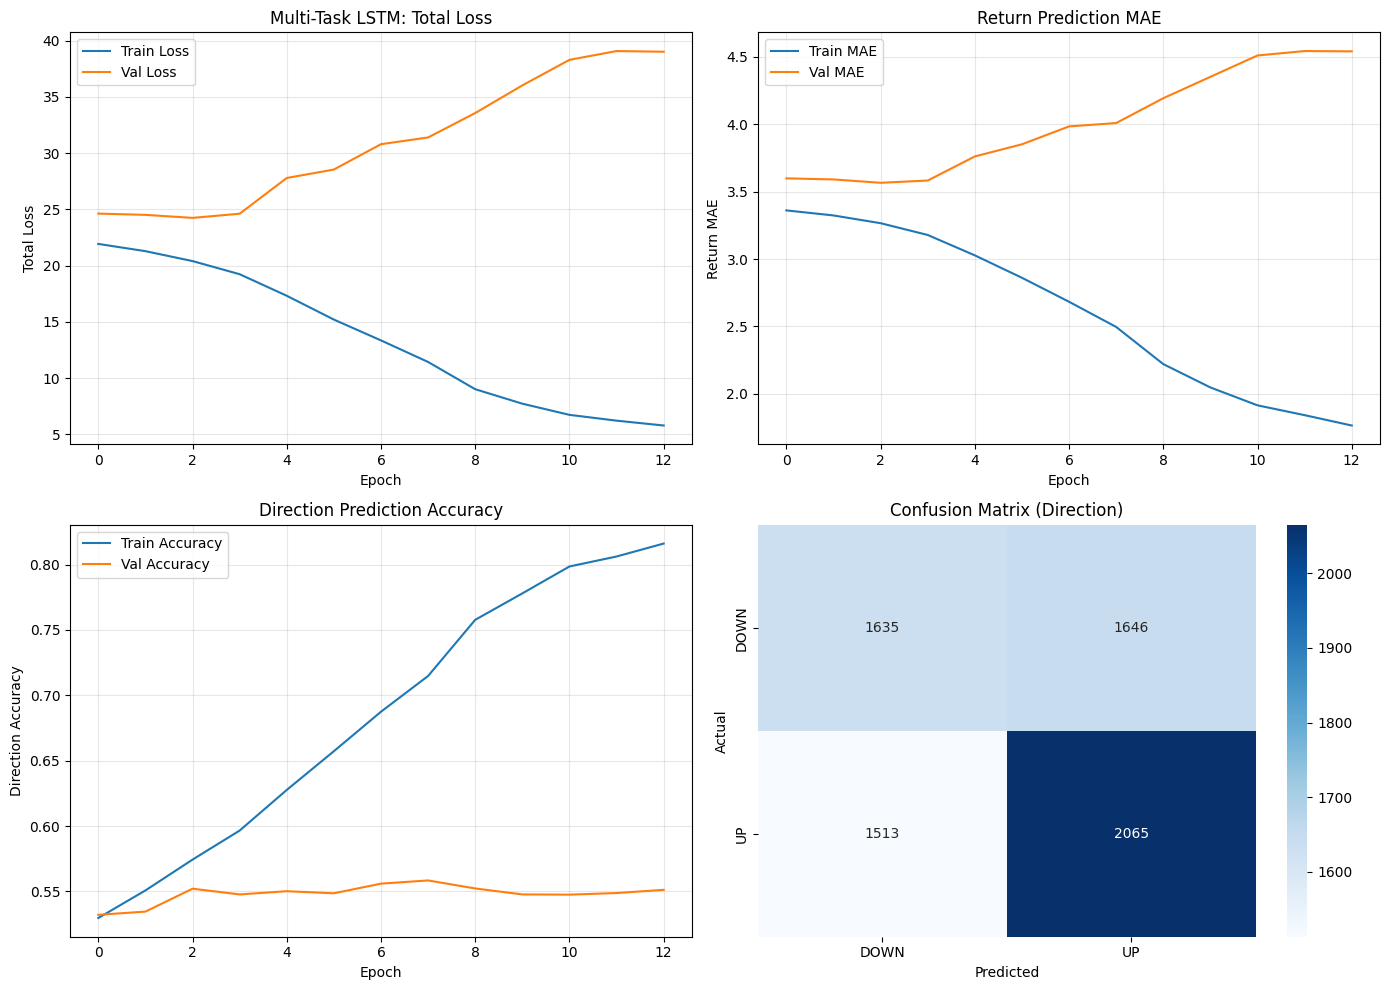


Results for Multi-Task LSTM

[REGRESSION] Return Prediction:
  MAE:   3.616%
  RMSE:  4.696%
  R²:    0.0004
  MAPE:  2846651.71%

[CLASSIFICATION] Direction Prediction:
  Accuracy:  53.94%
  Precision: 55.65%
  Recall:    57.71%
  F1-Score:  56.66%
  ROC-AUC:   0.5553

[TRADING SIMULATION]:
  Initial Capital:   ₹3,711,000.00 (3711 trades × ₹1,000)
  Final Capital:     ₹3,731,613.55
  Total Return:      0.56%
  Number of Trades:  3711
  Win Rate:          53.73%
  Avg Return/Trade:  0.555%
  Sharpe Ratio:      0.1206

Training time: 826.68s
Epochs trained: 13
Multi-Task LSTM complete


In [33]:
# Multi-task LSTM: Shared encoder, dual output heads
print("Running Multi-Task LSTM...\n")

with mlflow.start_run(run_name="MultiTask_LSTM"):
    # Hyperparameters
    lstm_units_1 = 128
    lstm_units_2 = 64
    dropout_rate = 0.3
    batch_size = 64
    epochs = 50
    learning_rate = 0.001
    alpha = 1.0  # Weight for regression loss
    beta = 1.0   # Weight for classification loss
    
    mlflow.log_param("model_type", "MultiTask_LSTM")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("lstm_units_1", lstm_units_1)
    mlflow.log_param("lstm_units_2", lstm_units_2)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("beta", beta)
    
    start_time = time.time()
    
    # Build model
    input_layer = layers.Input(shape=(WINDOW_SIZE, n_features), name='input')
    
    # Shared encoder
    x = layers.LSTM(lstm_units_1, return_sequences=True)(input_layer)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.LSTM(lstm_units_2)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # Output head 1: Return prediction (regression)
    return_output = layers.Dense(1, name='return_output')(x)
    
    # Output head 2: Direction prediction (classification)
    direction_output = layers.Dense(1, activation='sigmoid', name='direction_output')(x)
    
    # Create model
    model = models.Model(inputs=input_layer, outputs=[return_output, direction_output])
    
    # Compile with dual losses
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss={
            'return_output': 'mse',
            'direction_output': 'binary_crossentropy'
        },
        loss_weights={
            'return_output': alpha,
            'direction_output': beta
        },
        metrics={
            'return_output': ['mae'],
            'direction_output': ['accuracy']
        }
    )
    
    print(model.summary())
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    # Train
    history = model.fit(
        X_train_scaled,
        {
            'return_output': y_return_train,
            'direction_output': y_direction_train
        },
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Predict
    y_return_pred, y_direction_pred_proba = model.predict(X_test_scaled, verbose=0)
    y_return_pred = y_return_pred.flatten()
    y_direction_pred_proba = y_direction_pred_proba.flatten()
    y_direction_pred = (y_direction_pred_proba > 0.5).astype(int)
    
    # Evaluate
    reg_metrics = calculate_regression_metrics(y_return_test, y_return_pred)
    clf_metrics = calculate_classification_metrics(y_direction_test, y_direction_pred, y_direction_pred_proba)
    trading_metrics = simulate_trading(y_direction_test, y_direction_pred, y_return_test)
    
    # Log to MLflow
    for key, val in {**reg_metrics, **clf_metrics, **trading_metrics}.items():
        if key != 'trades':
            mlflow.log_metric(key, val)
    mlflow.log_metric("train_time_seconds", train_time)
    mlflow.log_metric("epochs_trained", len(history.history['loss']))
    
    # Log model
    mlflow.keras.log_model(model, "model")
    
    # Plot training history
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Total loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Total Loss')
    axes[0, 0].set_title('Multi-Task LSTM: Total Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Return MAE
    axes[0, 1].plot(history.history['return_output_mae'], label='Train MAE')
    axes[0, 1].plot(history.history['val_return_output_mae'], label='Val MAE')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Return MAE')
    axes[0, 1].set_title('Return Prediction MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Direction accuracy
    axes[1, 0].plot(history.history['direction_output_accuracy'], label='Train Accuracy')
    axes[1, 0].plot(history.history['val_direction_output_accuracy'], label='Val Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Direction Accuracy')
    axes[1, 0].set_title('Direction Prediction Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Confusion matrix
    cm = confusion_matrix(y_direction_test, y_direction_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    axes[1, 1].set_title('Confusion Matrix (Direction)')
    axes[1, 1].set_xticklabels(['DOWN', 'UP'])
    axes[1, 1].set_yticklabels(['DOWN', 'UP'])
    
    plt.tight_layout()
    plt.savefig('/tmp/multitask_lstm_results.png', dpi=150, bbox_inches='tight')
    mlflow.log_artifact('/tmp/multitask_lstm_results.png')
    plt.show()
    
    print_evaluation_summary("Multi-Task LSTM", reg_metrics, clf_metrics, trading_metrics)
    print(f"Training time: {train_time:.2f}s")
    print(f"Epochs trained: {len(history.history['loss'])}")

print("Multi-Task LSTM complete")

---
## 9. Multi-Task GRU

In [34]:
# Multi-task GRU: Similar to LSTM but faster
print("Running Multi-Task GRU...\n")

with mlflow.start_run(run_name="MultiTask_GRU"):
    # Hyperparameters
    gru_units_1 = 128
    gru_units_2 = 64
    dropout_rate = 0.3
    batch_size = 64
    epochs = 50
    learning_rate = 0.001
    alpha = 1.0
    beta = 1.0
    
    mlflow.log_param("model_type", "MultiTask_GRU")
    mlflow.log_param("window_size", WINDOW_SIZE)
    mlflow.log_param("horizon", HORIZON)
    mlflow.log_param("gru_units_1", gru_units_1)
    mlflow.log_param("gru_units_2", gru_units_2)
    mlflow.log_param("dropout_rate", dropout_rate)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("beta", beta)
    
    start_time = time.time()
    
    # Build model
    input_layer = layers.Input(shape=(WINDOW_SIZE, n_features), name='input')
    
    # Shared encoder
    x = layers.GRU(gru_units_1, return_sequences=True)(input_layer)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.GRU(gru_units_2)(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # Output heads
    return_output = layers.Dense(1, name='return_output')(x)
    direction_output = layers.Dense(1, activation='sigmoid', name='direction_output')(x)
    
    model = models.Model(inputs=input_layer, outputs=[return_output, direction_output])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss={
            'return_output': 'mse',
            'direction_output': 'binary_crossentropy'
        },
        loss_weights={
            'return_output': alpha,
            'direction_output': beta
        },
        metrics={
            'return_output': ['mae'],
            'direction_output': ['accuracy']
        }
    )
    
    print(model.summary())
    
    # Callbacks
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    # Train
    history = model.fit(
        X_train_scaled,
        {
            'return_output': y_return_train,
            'direction_output': y_direction_train
        },
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    train_time = time.time() - start_time
    
    # Predict
    y_return_pred, y_direction_pred_proba = model.predict(X_test_scaled, verbose=0)
    y_return_pred = y_return_pred.flatten()
    y_direction_pred_proba = y_direction_pred_proba.flatten()
    y_direction_pred = (y_direction_pred_proba > 0.5).astype(int)
    
    # Evaluate
    reg_metrics = calculate_regression_metrics(y_return_test, y_return_pred)
    clf_metrics = calculate_classification_metrics(y_direction_test, y_direction_pred, y_direction_pred_proba)
    trading_metrics = simulate_trading(y_direction_test, y_direction_pred, y_return_test)
    
    # Log to MLflow
    for key, val in {**reg_metrics, **clf_metrics, **trading_metrics}.items():
        if key != 'trades':
            mlflow.log_metric(key, val)
    mlflow.log_metric("train_time_seconds", train_time)
    mlflow.log_metric("epochs_trained", len(history.history['loss']))
    
    # Log model
    mlflow.keras.log_model(model, "model")
    
    print_evaluation_summary("Multi-Task GRU", reg_metrics, clf_metrics, trading_metrics)
    print(f"Training time: {train_time:.2f}s")
    print(f"Epochs trained: {len(history.history['loss'])}")

print("Multi-Task GRU complete")

Running Multi-Task GRU...



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 60, 32)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 60, 128)   │     62,208 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60, 128)   │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 64)        │     37,248 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ return_output       │ (None, 1)         │         65 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direction_output    │ (None, 1)         │         65 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,746 (405.26 KB)

 Trainable params: 103,746 (405.26 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2025-11-13 13:13:45.225463: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 175219200 exceeds 10% of free system memory.


357/357 ━━━━━━━━━━━━━━━━━━━━ 45s 113ms/step - direction_output_accuracy: 0.5205 - direction_output_loss: 0.6953 - loss: 21.9056 - return_output_loss: 21.2069 - return_output_mae: 3.3592 - val_direction_output_accuracy: 0.5056 - val_direction_output_loss: 0.6981 - val_loss: 24.7668 - val_return_output_loss: 23.8520 - val_return_output_mae: 3.6080 - learning_rate: 0.0010
Epoch 2/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - direction_output_accuracy: 0.5385 - direction_output_loss: 0.6884 - loss: 21.4864 - return_output_loss: 20.7938 - return_output_mae: 3.3391 - val_direction_output_accuracy: 0.5249 - val_direction_output_loss: 0.6920 - val_loss: 24.5242 - val_return_output_loss: 23.6176 - val_return_output_mae: 3.5979 - learning_rate: 0.0010
Epoch 3/50
357/357 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - direction_output_accuracy: 0.5569 - direction_output_loss: 0.6812 - loss: 20.7463 - return_output_loss: 20.0626 - return_output_mae: 3.2942 - val_direction_output_accuracy: 0.5270 - val_di

2025-11-13 13:22:43.900803: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 52677120 exceeds 10% of free system memory.
2025/11/13 13:22:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/13 13:22:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/11/13 13:23:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/11/13 13:23:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Results for Multi-Task GRU

[REGRESSION] Return Prediction:
  MAE:   3.500%
  RMSE:  4.557%
  R²:    0.0586
  MAPE:  2472205.79%

[CLASSIFICATION] Direction Prediction:
  Accuracy:  54.75%
  Precision: 56.23%
  Recall:    59.78%
  F1-Score:  57.95%
  ROC-AUC:   0.5673

[TRADING SIMULATION]:
  Initial Capital:   ₹3,804,000.00 (3804 trades × ₹1,000)
  Final Capital:     ₹3,827,135.05
  Total Return:      0.61%
  Number of Trades:  3804
  Win Rate:          54.13%
  Avg Return/Trade:  0.608%
  Sharpe Ratio:      0.1311

Training time: 541.63s
Epochs trained: 12
Multi-Task GRU complete


---
## 10. Results Summary & Comparison

In [3]:
# Query all runs from experiment
experiment = mlflow.get_experiment_by_name("stock-return-prediction-multihorizon")
runs_df = mlflow.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.sharpe_ratio DESC"]
)

print(f"Total runs: {len(runs_df)}\n")

# Select columns
summary_cols = [
    'tags.mlflow.runName',
    'metrics.accuracy',
    'metrics.f1',
    'metrics.mae',
    'metrics.sharpe_ratio',
    'metrics.total_return_pct',
    'metrics.win_rate',
    'metrics.train_time_seconds'
]

summary_df = runs_df[summary_cols].copy()
summary_df.columns = ['Model', 'Accuracy', 'F1', 'MAE', 'Sharpe', 'Total Return %', 'Win Rate', 'Train Time (s)']
summary_df = summary_df.sort_values('Sharpe', ascending=False)

print("\n" + "="*100)
print("MODEL COMPARISON - Ranked by Sharpe Ratio (Higher is Better)")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Best model
if len(summary_df) > 0:
    best_model = summary_df.iloc[0]
    print(f"\nBEST MODEL: {best_model['Model']}")
    print(f"   Directional Accuracy: {best_model['Accuracy']*100:.2f}%")
    print(f"   F1 Score:             {best_model['F1']*100:.2f}%")
    print(f"   Return MAE:           {best_model['MAE']:.3f}%")
    print(f"   Sharpe Ratio:         {best_model['Sharpe']:.4f}")
    print(f"   Total Return:         {best_model['Total Return %']:.2f}%")
    print(f"   Win Rate:             {best_model['Win Rate']*100:.2f}%")

Total runs: 4


MODEL COMPARISON - Ranked by Sharpe Ratio (Higher is Better)
         Model  Accuracy       F1      MAE   Sharpe  Total Return %  Win Rate  Train Time (s)
 Linear_Models  0.588132 0.608020 3.487745 0.209492        0.942082  0.585561      166.927659
 MultiTask_GRU  0.547456 0.579518 3.500421 0.131135        0.608177  0.541272      541.631627
MultiTask_LSTM  0.539437 0.566607 3.616054 0.120582        0.555472  0.537321      826.677635
Naive_Baseline  0.498469 0.506598 3.589600 0.024785        0.118323  0.496170        0.160343

BEST MODEL: Linear_Models
   Directional Accuracy: 58.81%
   F1 Score:             60.80%
   Return MAE:           3.488%
   Sharpe Ratio:         0.2095
   Total Return:         0.94%
   Win Rate:             58.56%


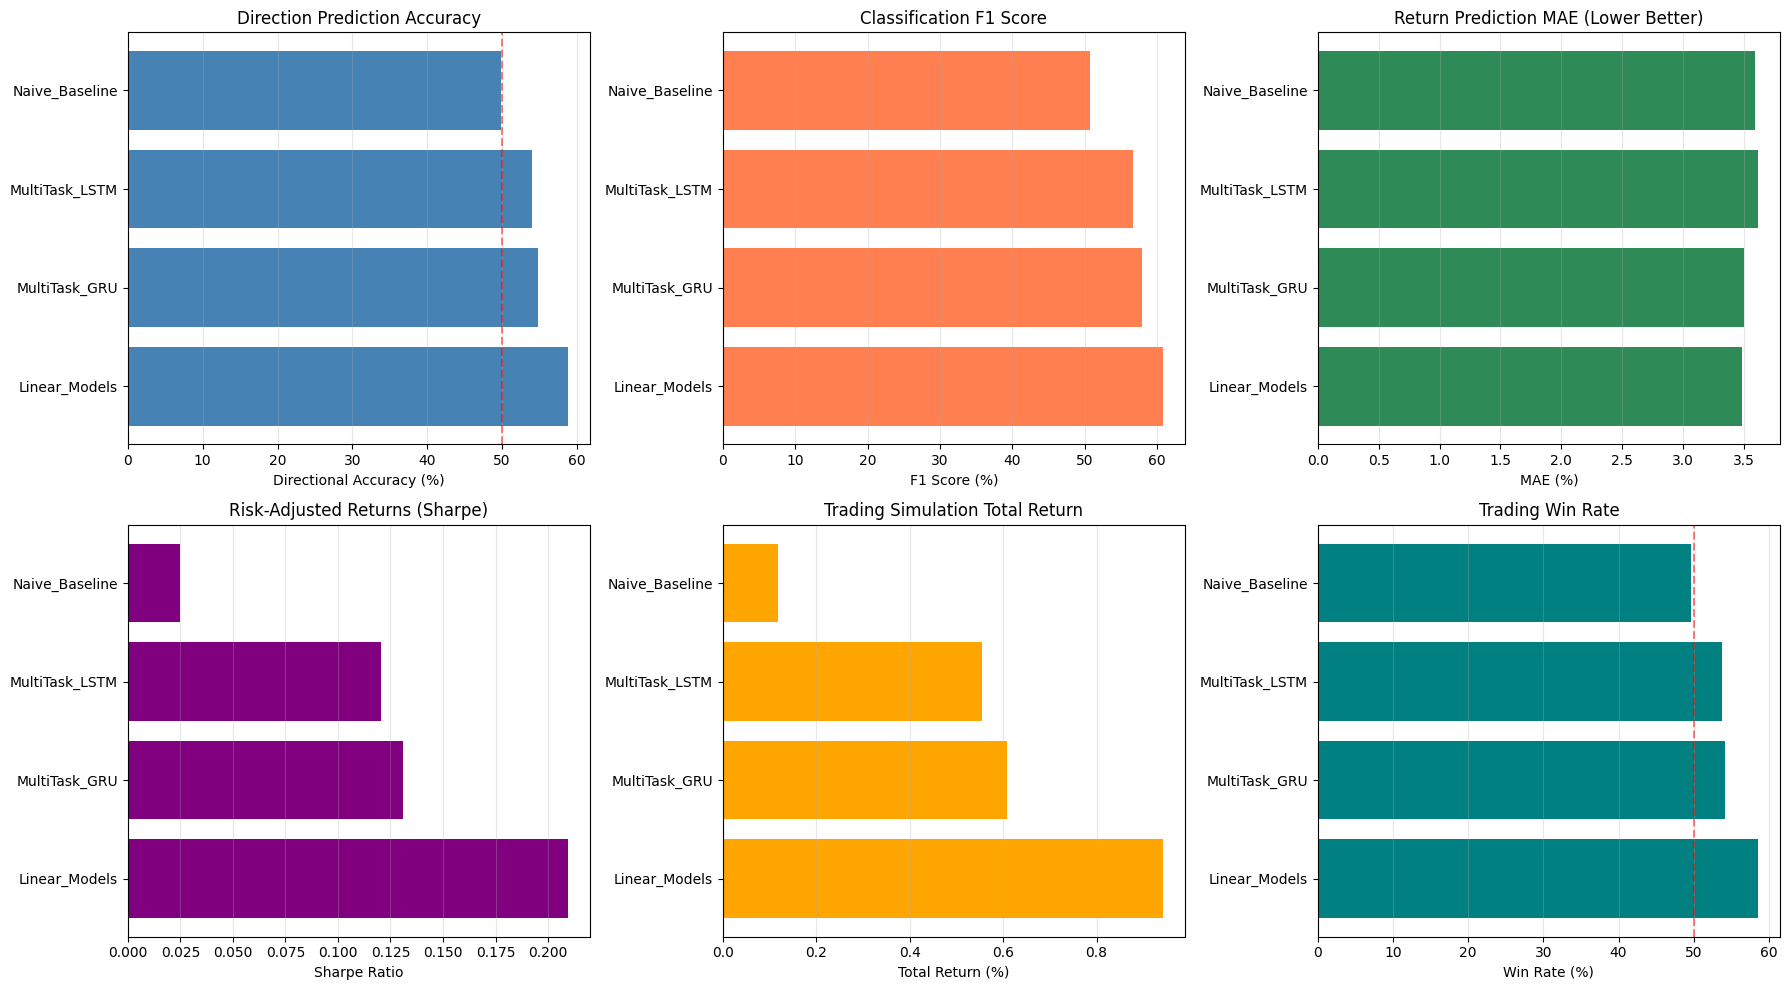

Model comparison visualization complete


In [4]:
# Visualization: Model comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy
axes[0, 0].barh(summary_df['Model'], summary_df['Accuracy']*100, color='steelblue')
axes[0, 0].set_xlabel('Directional Accuracy (%)')
axes[0, 0].set_title('Direction Prediction Accuracy')
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].axvline(x=50, color='red', linestyle='--', alpha=0.5, label='Random (50%)')

# F1 Score
axes[0, 1].barh(summary_df['Model'], summary_df['F1']*100, color='coral')
axes[0, 1].set_xlabel('F1 Score (%)')
axes[0, 1].set_title('Classification F1 Score')
axes[0, 1].grid(axis='x', alpha=0.3)

# MAE
axes[0, 2].barh(summary_df['Model'], summary_df['MAE'], color='seagreen')
axes[0, 2].set_xlabel('MAE (%)')
axes[0, 2].set_title('Return Prediction MAE (Lower Better)')
axes[0, 2].grid(axis='x', alpha=0.3)

# Sharpe Ratio
axes[1, 0].barh(summary_df['Model'], summary_df['Sharpe'], color='purple')
axes[1, 0].set_xlabel('Sharpe Ratio')
axes[1, 0].set_title('Risk-Adjusted Returns (Sharpe)')
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Total Return
axes[1, 1].barh(summary_df['Model'], summary_df['Total Return %'], color='orange')
axes[1, 1].set_xlabel('Total Return (%)')
axes[1, 1].set_title('Trading Simulation Total Return')
axes[1, 1].grid(axis='x', alpha=0.3)
axes[1, 1].axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Win Rate
axes[1, 2].barh(summary_df['Model'], summary_df['Win Rate']*100, color='teal')
axes[1, 2].set_xlabel('Win Rate (%)')
axes[1, 2].set_title('Trading Win Rate')
axes[1, 2].grid(axis='x', alpha=0.3)
axes[1, 2].axvline(x=50, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('/tmp/model_comparison_multihorizon.png', dpi=150, bbox_inches='tight')
plt.show()

print("Model comparison visualization complete")

---
## Summary

### Key Takeaways:


### Next Steps:


### MLflow UI:
```bash
cd /home/labeeb/Desktop/stock-curator
uv run mlflow ui --port 5000
# Visit: http://localhost:5000
```

---

**Notebook Complete!**